<a href="https://colab.research.google.com/github/deepakgoyal17/APIHacathon-2020/blob/master/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import os
import datetime
import os
from imageio import imread
import cv2

In [31]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [32]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Project_data.zip", 'r')
zip_ref.extractall("/content/data/tmp")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [33]:
train_doc = np.random.permutation(open('/content/data/tmp/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/data/tmp/Project_data/val.csv').readlines())
batch_size = 64

Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [34]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [35]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/data/tmp/Project_data/train'
val_path = '/content/data/tmp/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


Model

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

Let us create the train_generator and the val_generator which will be used in .fit_generator

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [37]:
# function to plot the training/validation accuracies/losses.
import cv2
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [38]:
def define_model1(filtersize=(2,2,2),dense_neurons=64,dropout=0.25):

  model = Sequential()
  model.add(Conv3D(64, filtersize, strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  model.add(Conv3D(128, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  return model

In [39]:
def train_model( model):
        train_generator = generator(train_path, train_doc,batch_size)
        val_generator = generator(val_path, val_doc,batch_size)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        callbacks_list = [checkpoint, LR]
        #callbacks_list = [checkpoint, LR, earlystop]
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

In [40]:
batch_size = 10
num_epochs = 5

In [41]:
model = define_model1()
optimiser = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 84, 84, 64)    1600      
                                                                 
 batch_normalization_12 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 42, 84, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 42, 84, 128)    65664     
                                                                 
 batch_normalization_13 (Bat  (None, 9, 42, 84, 128)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [42]:
history_model1 = train_model(model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Source path =  /content/data/tmp/Project_data/train ; batch size = 10
Epoch 1/5
67/67 [==============================] - ETA: 0s - loss: 3.5143 - categorical_accuracy: 0.3092Source path =  /content/data/tmp/Project_data/val ; batch size = 10

Epoch 1: val_loss improved from inf to 2.24579, saving model to model_init_2022-09-1216_37_19.372187/model-00001-3.51427-0.30920-2.24579-0.29000.h5
67/67 [==============================] - 45s 652ms/step - loss: 3.5143 - categorical_accuracy: 0.3092 - val_loss: 2.2458 - val_categorical_accuracy: 0.2900 - lr: 0.0020
Epoch 2/5
67/67 [==============================] - ETA: 0s - loss: 1.4122 - categorical_accuracy: 0.3725
Epoch 2: val_loss improved from 2.24579 to 1.29017, saving model to model_init_2022-09-1216_37_19.372187/model-00002-1.41216-0.37255-1.29017-0.47000.h5
67/67 [==============================] - 41s 611ms/step - loss: 1.4122 - categorical_accuracy: 0.3725 - val_loss: 1.2902 - val_categorical_accuracy: 0.4700 - lr: 0.0020
Epoch 3/5
67/6

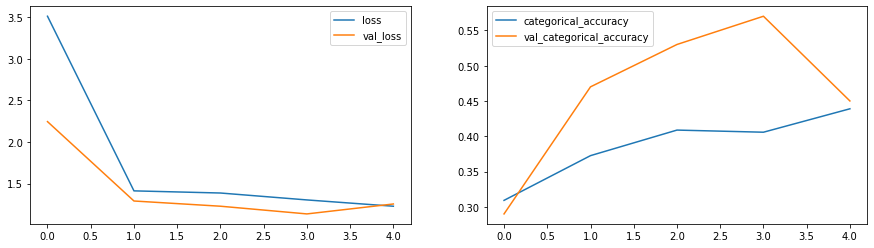

In [58]:
plot(history_model1)

Changing Epochs and Batch Size and activation function

In [43]:
def define_model2(filtersize=(2,2,2),dense_neurons=64,dropout=0.25):

  model = Sequential()
  model.add(Conv3D(64, filtersize, strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  model.add(Conv3D(128, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  return model

In [44]:
batch_size = 20
num_epochs = 10

In [45]:
model = define_model2()
optimiser = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 18, 84, 84, 64)    1600      
                                                                 
 batch_normalization_16 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 9, 42, 84, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 9, 42, 84, 128)    65664     
                                                                 
 batch_normalization_17 (Bat  (None, 9, 42, 84, 128)  

In [46]:
history_model2 = train_model(model)

Source path =  /content/data/tmp/Project_data/train ; batch size = 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 4.0304 - categorical_accuracy: 0.3469Source path =  /content/data/tmp/Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 3.76653, saving model to model_init_2022-09-1216_40_42.637797/model-00001-4.03041-0.34691-3.76653-0.29000.h5
34/34 [==============================] - 41s 1s/step - loss: 4.0304 - categorical_accuracy: 0.3469 - val_loss: 3.7665 - val_categorical_accuracy: 0.2900 - lr: 0.0020
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.4175 - categorical_accuracy: 0.5385
Epoch 2: val_loss improved from 3.76653 to 2.84023, saving model to model_init_2022-09-1216_40_42.637797/model-00002-1.41749-0.53846-2.84023-0.38000.h5
34/34 [==============================] - 38s 1s/step - loss: 1.4175 - categorical_accuracy: 0.5385 - val_loss: 2.8402 - val_categorical_accuracy: 0.3800 - lr: 0.0020
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4368 - categorical

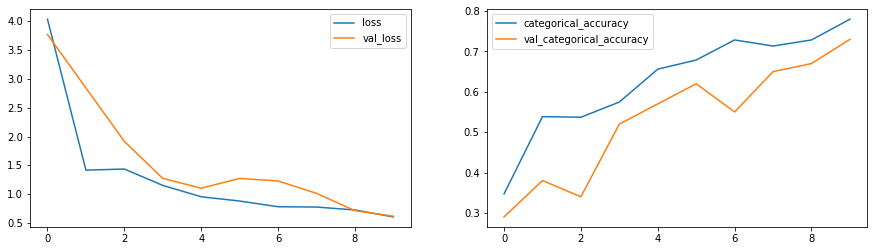

In [47]:
plot(history_model2)

In [48]:
def define_model3(filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

  model = Sequential()
  model.add(Conv3D(64, filtersize, strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  model.add(Conv3D(128, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  return model

In [49]:
batch_size = 32
num_epochs = 20

In [50]:
model = define_model3()
optimiser = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_20 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 42, 84, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_21 (Bat  (None, 9, 42, 84, 128)  

In [51]:
history_model3 = train_model(model)

Source path =  /content/data/tmp/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 3.8905 - categorical_accuracy: 0.3741Source path =  /content/data/tmp/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 11.80298, saving model to model_init_2022-09-1216_47_25.040867/model-00001-3.89054-0.37406-11.80298-0.23000.h5
21/21 [==============================] - 42s 2s/step - loss: 3.8905 - categorical_accuracy: 0.3741 - val_loss: 11.8030 - val_categorical_accuracy: 0.2300 - lr: 0.0020
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5631 - categorical_accuracy: 0.5158
Epoch 2: val_loss improved from 11.80298 to 10.36067, saving model to model_init_2022-09-1216_47_25.040867/model-00002-1.56308-0.51584-10.36067-0.21000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.5631 - categorical_accuracy: 0.5158 - val_loss: 10.3607 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2929 - cate

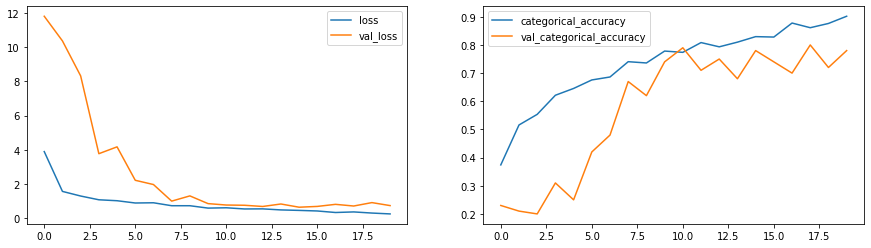

In [52]:
plot(history_model3)

In [53]:
def define_model4(filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

  model = Sequential()
  model.add(Conv3D(64, filtersize, strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  model.add(Conv3D(128, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  # model.add(Dropout(0.25))

  model.add(Conv3D(256, filtersize, strides=(1,1,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('elu'))
  model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  return model

In [54]:
batch_size = 32
num_epochs = 30

In [55]:
model = define_model4()
optimiser = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_24 (Bat  (None, 18, 84, 84, 64)   256       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 9, 42, 84, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_25 (Bat  (None, 9, 42, 84, 128)  

In [56]:
history_model4 = train_model(model)

Source path =  /content/data/tmp/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 4.1505 - categorical_accuracy: 0.3710Source path =  /content/data/tmp/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 14.19664, saving model to model_init_2022-09-1217_00_58.937392/model-00001-4.15053-0.37104-14.19664-0.22000.h5
21/21 [==============================] - 41s 2s/step - loss: 4.1505 - categorical_accuracy: 0.3710 - val_loss: 14.1966 - val_categorical_accuracy: 0.2200 - lr: 0.0020
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6576 - categorical_accuracy: 0.4827
Epoch 2: val_loss improved from 14.19664 to 7.78779, saving model to model_init_2022-09-1217_00_58.937392/model-00002-1.65762-0.48265-7.78779-0.25000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.6576 - categorical_accuracy: 0.4827 - val_loss: 7.7878 - val_categorical_accuracy: 0.2500 - lr: 0.0020
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.2651 - categor

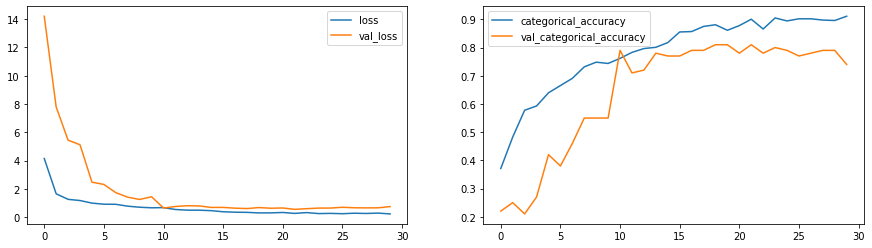

In [57]:
plot(history_model4)